In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,CuDNNLSTM
from tensorflow import keras

In [4]:
train = pd.read_csv('/content/drive/MyDrive/toxic_5.csv')

In [5]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [6]:
x=train["comment_text"]
y=train["Toxic"]

In [7]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=1,shuffle=True)

In [8]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [9]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
bi_model=Sequential()
bi_model.add(hub_layer)
bi_model.add(tf.keras.layers.Reshape((1,128)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(128,return_sequences=True)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(128))) #lstm with 100 neurons
bi_model.add(Dropout(0.3))
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           264192    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              395264    
 nal)                                                   

In [10]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=2, mode='auto', restore_best_weights=True)
history = bi_model.fit(x=train_x, y=train_y, batch_size=128, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
231/231 [==============================] - 36s 130ms/step - loss: 0.3262 - accuracy: 0.8625 - val_loss: 0.2811 - val_accuracy: 0.8797
Epoch 2/20
231/231 [==============================] - 28s 122ms/step - loss: 0.1790 - accuracy: 0.9286 - val_loss: 0.3062 - val_accuracy: 0.8739
Epoch 3/20
231/231 [==============================] - 28s 122ms/step - loss: 0.1038 - accuracy: 0.9577 - val_loss: 0.4515 - val_accuracy: 0.8660
Epoch 4/20
231/231 [==============================] - 28s 122ms/step - loss: 0.0734 - accuracy: 0.9682 - val_loss: 0.5026 - val_accuracy: 0.8630
Epoch 5/20
231/231 [==============================] - 28s 121ms/step - loss: 0.0544 - accuracy: 0.9785 - val_loss: 0.5233 - val_accuracy: 0.8648
Epoch 6/20
231/231 [==============================] - 28s 121ms/step - loss: 0.0374 - accuracy: 0.9861 - val_loss: 0.6375 - val_accuracy: 0.8627
Epoch 7/20
231/231 [==============================] - 28s 122ms/step - loss: 0.0260 - accuracy: 0.9902 - val_loss: 0.6900 - val_ac

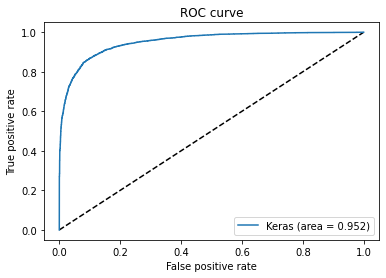

In [12]:
from sklearn.metrics import roc_curve
y_pred=bi_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [13]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.5684738
              precision    recall  f1-score   support

           0     0.8804    0.8987    0.8894      4234
           1     0.8896    0.8699    0.8796      3974

    accuracy                         0.8847      8208
   macro avg     0.8850    0.8843    0.8845      8208
weighted avg     0.8848    0.8847    0.8847      8208



In [16]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape_1 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,161
Trainable params: 124,692,161
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_____________

In [15]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=128, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
231/231 [==============================] - 31s 123ms/step - loss: 0.2335 - accuracy: 0.9140 - val_loss: 0.2994 - val_accuracy: 0.8752
Epoch 2/20
231/231 [==============================] - 27s 119ms/step - loss: 0.1205 - accuracy: 0.9550 - val_loss: 0.3905 - val_accuracy: 0.8636
Epoch 3/20
231/231 [==============================] - 27s 119ms/step - loss: 0.0724 - accuracy: 0.9716 - val_loss: 0.4684 - val_accuracy: 0.8611
Epoch 4/20
231/231 [==============================] - 27s 118ms/step - loss: 0.0460 - accuracy: 0.9809 - val_loss: 0.5724 - val_accuracy: 0.8627
Epoch 5/20
231/231 [==============================] - 27s 119ms/step - loss: 0.0339 - accuracy: 0.9849 - val_loss: 0.7433 - val_accuracy: 0.8602
Epoch 6/20
231/231 [==============================] - 28s 119ms/step - loss: 0.0261 - accuracy: 0.9894 - val_loss: 0.8069 - val_accuracy: 0.8569
Epoch 7/20
231/231 [==============================] - 27s 119ms/step - loss: 0.0219 - accuracy: 0.9912 - val_loss: 0.8789 - val_ac

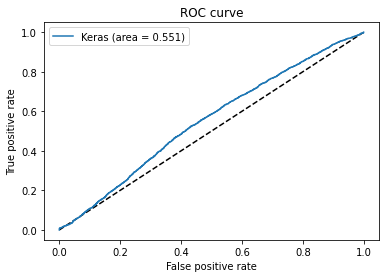

In [17]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [18]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.48745725
              precision    recall  f1-score   support

           0     0.5597    0.5661    0.5629      4234
           1     0.5320    0.5254    0.5287      3974

    accuracy                         0.5464      8208
   macro avg     0.5458    0.5458    0.5458      8208
weighted avg     0.5463    0.5464    0.5463      8208

